# 사용법
- import math 추가
- stratified k fold 함수 추가
- CostomDatoLoader 셀 수정
- Loader에 넣는 셀 수정

In [8]:
import os
import random
import time
import json
import warnings 
import math
from tqdm import tqdm

warnings.filterwarnings('ignore')

import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader
# from torch.cuda.amp import autocast, GradScaler

from model import *
from utils import *
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms


import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from adamp import AdamP

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


# EMANet

성공한 실험 version03으로부터 mIoU 재설정, 이후에 lr 5e-5실험, mIoU 재설정하면서 /255. 안빼줘서 학습 힘든건가??

### 모든 하이퍼파라미터는 여기서 세팅 및 seed 고정

In [9]:
model_list = {'FCN8s':FCN8s, 'EMANet': EMANet}
loss_list = {'CE':nn.CrossEntropyLoss,}
optim_list = {'Adam':optim.Adam, 'AdamP':AdamP}
scheduler_list = {'cosine_warm':CosineAnnealingWarmRestarts}

In [10]:
class CFG:
    version = 'v05_strati'
    
    # 하이퍼 파라미터 설정
    batch_size = 2
    num_epochs = 130
    lr = 5e-6
    SEED = 21
    num_classes = 12
    weight_decay = 1e-6
    loss_weight = None
    input_size = 512
    
    T_0 = 10
    T_mult = 2

    # Model, Loss, Optimizer 및 하이퍼 파라미터 선택
    model = 'FCN8s' # FCN8s, EMANet,  
    model_params = {
        'FCN8s':{'num_classes':num_classes},
        'EMANet':{'n_classes':12, 'n_layers':101}
    }
    loss = 'CE' # CE , 
    loss_params = {
        'CE':{'weight':loss_weight},
    }
    optim = 'AdamP' # Adam , AdamP
    optim_params = {
        'Adam':{'lr':lr,'weight_decay':weight_decay},
        'AdamP':{'lr':lr,'weight_decay':weight_decay},
    }
    scheduler = 'cosine_warm'
    scheduler_params = {
        'cosine_warm':{'T_0':T_0, 'T_mult':T_mult}
    }

In [11]:
# seed 고정
every_seed(CFG.SEED)

## 학습 데이터 EDA

In [12]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


In [13]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)


In [14]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [17]:
def stratified_k_fold(coco_obj, n_split=5, shuffle=False, random_state=None):
    fold_list = [([],[]) for _ in range(n_split)]
    all_ImgIds = set(coco_obj.getImgIds()) # 모든 이미지 set
    for i in [9, 0, 10, 5, 4, 3, 6, 7, 1, 2, 8]: # 적은순서 cat
        if random_state is not None:
            np.random.seed(random_state)
        cat_set = set(coco_obj.getImgIds(catIds=i)) & all_ImgIds
        all_ImgIds = all_ImgIds-cat_set
        cat_arr = np.array(list(cat_set))
        if shuffle:
            np.random.shuffle(cat_arr)
        for j in range(n_split):
            cut = len(cat_arr)/n_split
            val_arr = cat_arr[math.floor(cut*(j)):math.floor(cut*(j+1))]
            train_arr = list(set(cat_arr)-set(val_arr))
            fold_list[j][0].extend(train_arr)
            fold_list[j][1].extend(val_arr)
    return fold_list

## 데이터 전처리 함수 정의 (Dataset)

In [31]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, k, n_split=5, mode = 'train', transform = None, strati_random_seed=None):
        super().__init__()
        self.k = k
        self.n_split = n_split
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.fold_list = stratified_k_fold(self.coco, n_split=5, shuffle=True, random_state=strati_random_seed)
        self.kth_fold = self.fold_list[self.k]
        
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        if self.mode == 'train':
            image_id = self.kth_fold[0]
        elif self.mode == 'val':
            image_id = self.kth_fold[1]
        elif self.mode == 'test':
            image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]

        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)

        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]

            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [34]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'
all_path = dataset_path + '/train_all.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            ),                           
                            ToTensorV2(transpose_mask=True)
                          ])

val_transform = A.Compose([
                            A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            ),                           
                            ToTensorV2(transpose_mask=True)
                          ])

test_transform = A.Compose([
                            A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            ),    
                    ToTensorV2(transpose_mask=True)
        ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
#####                             몇번째 k를 선택하는지는 수동입니다...
# train dataset
train_dataset = CustomDataLoader(data_dir=all_path, n_split=5, k=0, mode='train', transform=train_transform, strati_random_seed=CFG.SEED)

# validation dataset
val_dataset = CustomDataLoader(data_dir=all_path, n_split=5, k=0, mode='val', transform=val_transform, strati_random_seed=CFG.SEED)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, n_split=5, k=0, mode='test', transform=test_transform, strati_random_seed=CFG.SEED)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=CFG.batch_size,
                                           shuffle=True,
                                           drop_last=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=CFG.batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=CFG.batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=5.10s)
creating index...
index created!
loading annotations into memory...
Done (t=5.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Model Init

In [20]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
model_name = CFG.model
model = model_list[model_name](**CFG.model_params[model_name])

x = torch.randn([1, 3, CFG.input_size, CFG.input_size])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([1, 3, 512, 512])
output shape :  torch.Size([1, 12, 512, 512])


## train, validation, test 함수 정의

In [21]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_miou = 0
    best_loss = 9999999
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_miou = validation(epoch + 1, model, val_loader, criterion, device)
            if val_miou > best_miou:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_miou = val_miou
                save_model(model, saved_dir)
            if epoch % 10 == 0 and epoch > 50:
                torch.save(model.state_dict(), './saved/'+str(epoch)+'.pt')

In [22]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    hist = np.zeros((12,12))
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()

            hist = add_hist(hist, masks.detach().cpu().numpy(), outputs, n_class=12)
            
        acc, acc_cls, mIoU, fwavacc = label_accuracy_score(hist)
        # mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
        # mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, mIoU))

    return avrg_loss, mIoU

## 모델 저장 함수 정의

In [23]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name=f'{CFG.version}.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [24]:
# Loss function 정의
loss_name = CFG.loss
criterion = loss_list[loss_name](**CFG.loss_params[loss_name])

# Optimizer 정의
optim_name = CFG.optim
optimizer = optim_list[optim_name](params = model.parameters(), **CFG.optim_params[optim_name])

scheduler_name = CFG.scheduler
scheduler = scheduler_list[scheduler_name](optimizer, **CFG.scheduler_params[scheduler_name])

In [35]:
train(CFG.num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/130], Step [25/1636], Loss: 2.4693
Epoch [1/130], Step [50/1636], Loss: 2.4384
Epoch [1/130], Step [75/1636], Loss: 2.3695
Epoch [1/130], Step [100/1636], Loss: 2.2298


KeyboardInterrupt: 

## 저장된 model 불러오기 (학습된 이후) 

In [16]:
# best model 저장된 경로
model_path = f'./saved/{CFG.version}.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
model.eval()

EMANet(
  (extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.0003, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.0003, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.0003, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, mome

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Plastic', 7}, {9, 'Plastic bag'}, {11, 'Clothing'}]


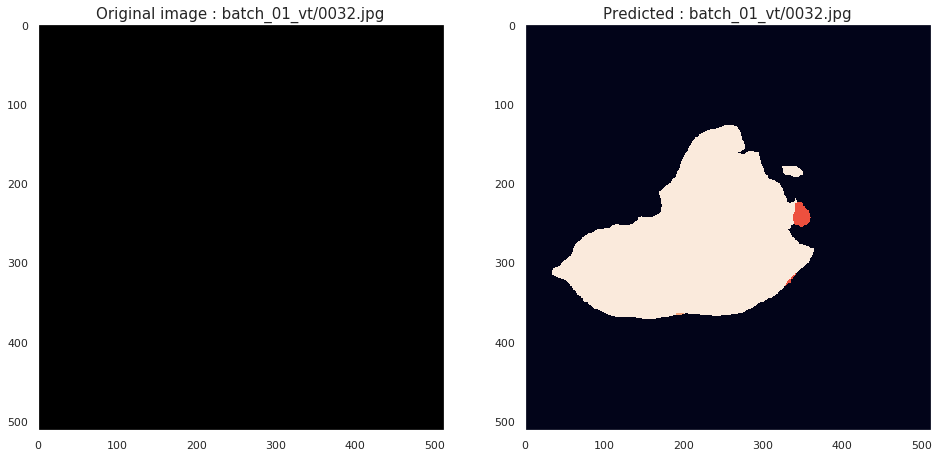

In [17]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [18]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(temp_images), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [44]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(f"./submission/{CFG.version}.csv", index=False)

Start prediction.
End prediction.


## hyper-param 저장